In [2]:
# Set notebook to use only one GPU
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


# Results Analysis

Analyse results


In [3]:
from file_functions import *
from models_bachelors import *
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd
from sklearn.metrics import accuracy_score
from plotly.subplots import make_subplots
import plotly.graph_objects as go

standard = {'lockbox': {'labels': 0,
                             'preds': 0},
            'test':    {'labels': 0,
                        'preds': 0}}

            
# Both are dicts with keys: 'lockbox_preds_lst' and 'preds_lst'. With
with h5py.File('predictions_standard.h5', 'r') as file: 
    for group in file.keys():
        for dset in file[group].keys():
            standard[dset][group] = file[group][dset][()]   

Using TensorFlow backend


Keras Uncertainty will use standalone Keras backend

In [4]:
def get_corrects(Y_true, Y_pred, axis):
    return np.argmax(Y_true, axis=axis) == np.argmax(Y_pred, axis=axis)

'''
Takes as input, a dict of predictions and labels as such:
{'preds': np.ndarray, 'labels': np.ndarray}
'''
def avg_pred_entropy_plots(dataset):
    entropy = predictive_uncertainty(dataset['preds'])    # shape: (9,576)
    Y_true = dataset['labels']    # shape: (9,576,4)
    corrects = get_corrects(Y_true, dataset['preds'], axis=-1) # Get corrects across ALL subjects
    entropy_correct = entropy[corrects]
    entropy_wrong = entropy[~corrects]
    # For distribution plots of predictive entropy
    hist_data = [entropy_correct, entropy_wrong]
    group_labels = ['Correct', 'Incorrect']
    fig = ff.create_distplot(hist_data, group_labels, bin_size=.05)
    fig.show()

# Rejection use case
Makes no sense to use the interpretability usecase for motor imagery data. Maybe it might be useful for determining how parts of a sample contribute to uncertainty and final output.
Make the following graphs:
- Distribution of Average normalised predictive entropy for incorrect and correct predictions per test subject and lockbox per method. 
- Accuracy confidence plots for both methods on test and lockbox set.

In [5]:
methods = {'standard': standard}

### Average normalised predictive entropy
This snippet generates distributions of average normalised predictive entropy (across all test subjects) for both the test and lockbox set.


In [ ]:
for name, method in methods.items():
    avg_pred_entropy_plots(method['test'])
    avg_pred_entropy_plots(method['lockbox'])

### Accuracy-coverage plots
These plots are to select a threshold for treating uncertainty as a binary classification task. Once the threshold is selected from the plot, you can compute the uncertainty accuracy, precision, sensitivity, specificity ROC plots and AUROC.

So accuracy and coverage will be computed for predictions that are above a certain uncertainty threshold

Explanations for very poor entropy based accuracy-coverage plots:
Because of high inter-subject variability, the specific model is unable to fully learn subject-independent features, leading to a high degree of epistemic uncertainty (my theory). Maybe I can confirm this by disentangling uncertainty... 

/home/pmanivannan/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/pmanivannan/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


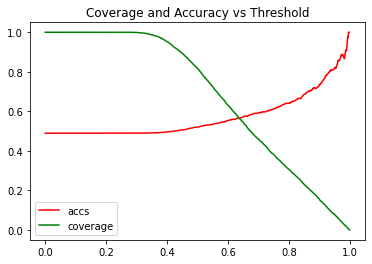

threshold value for standard: 0.637
 acc at threshold: 0.5650837034506321


In [58]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

thresholds = np.arange(0, 1.001, 0.001)

for name, method in methods.items():
    accs = []
    coverages = []
    y_pred = np.vstack(method['test']['preds'])
    y_true = np.vstack(method['test']['labels'])
    unc = predictive_uncertainty(y_pred)
    for t in thresholds:
        # accepted_idx = unc > t            # Thresholds against predictive normalised entropy
        accepted_idx = y_pred.max(axis=1) > t           # Thresholds against predicted probs...
        coverages.append(sum(accepted_idx) / y_test.shape[0])                           # Coverage: How many samples rejected
        acc = accuracy_score(y_pred=y_pred.argmax(axis=1)[accepted_idx], y_true=y_true.argmax(axis=1)[accepted_idx])  # Accuracy of accepted samples
        accs.append(acc)

    coverages = np.array(coverages)
    accs = np.array(accs)

    plt.plot(thresholds, accs, color='red', label='accs')
    plt.plot(thresholds, coverages, color='green', label='coverage')

    plt.title('Coverage and Accuracy vs Threshold')
    plt.legend()
    # plt.savefig('threshold_plots.png')
    plt.show()

    # Finding equivalent threshold value
    point = np.hstack(np.argwhere(accs > coverages))
    print(f'threshold value for {name}: {point[0] * 0.001}\n acc at threshold: {accs[point[0]]}')



# Redundant code
This section contains per-subject subplot generation methods. Took a long time to find out how to make distribution subplots in plotly so use it well.

In [ ]:
# Avg predictive entropy on test set for both methods
# acc_mcdropout = []
# acc_mcdropconnect = []
acc_standard = []

# methods = {'mcdropconnect': mcdropconnect, 'mcdropout':mcdropout, 'standard': standard}
methods = {'standard': standard}

for name, method in methods.items():
    entropy = predictive_uncertainty(method['test']['preds'])    # shape: (9,576)
    Y_true = method['test']['labels']    # shape: (9,576,4)
    # corrects = np.argmax(Y_true, axis=-1) == np.argmax(method['test']['preds'], axis=-1)    # axis -1 if (9,576,4). Also get corrects across ALL subjects
    # entropy_correct = entropy[corrects]
    # entropy_wrong = entropy[~corrects]
    trues = np.argmax(Y_true, axis=-1)
    preds = np.argmax(method['test']['preds'], axis=-1)
    # # For distribution plots of predictive entropy
    # hist_data = [entropy_correct, entropy_wrong]
    # group_labels = ['Correct', 'Incorrect']
    # fig = ff.create_distplot(hist_data, group_labels, bin_size=.05)
    # fig.show()
    fig = make_subplots(rows=3,cols=3, subplot_titles=[f'Subj.{x}' for x in range(0,9)])
    for r in range(1,4):
        for col in range(1,4):
            # World's most convoluted formula for finding out the cell number istg
            subj_id = (3 * r) - 4 + col
            corrects = np.argmax(Y_true[subj_id], axis=-1) == np.argmax(method['test']['preds'][subj_id], axis=-1)
            entropy_correct = entropy[subj_id][corrects]
            entropy_wrong = entropy[subj_id][~corrects]
            hist_data = [entropy_correct, entropy_wrong]
            group_labels = ['Corr.', 'Incorr.']
            sub = ff.create_distplot(hist_data, group_labels, bin_size=0.05)
            for trace in sub.select_traces(3):
                fig.add_trace(trace, row=r, col=col)
            for trace in sub.select_traces(2):
                fig.add_trace(trace, row=r, col=col)

    fig.show()
    for idx, subject in enumerate(trues):
        acc = accuracy_score(y_true=subject, y_pred=preds[idx], normalize=True)
        if name == 'mcdropconnect':
            acc_mcdropconnect.append(acc)
        elif name == 'mcdropout':
            acc_mcdropout.append(acc)
        else:
            acc_standard.append(acc)

print(f'acc_mcdropconnect:{np.mean(acc_mcdropconnect)}')
print(f'acc_mcdropout:{np.mean(acc_mcdropout)}')
print(f'acc_std:{np.mean(acc_standard)}')
        

In [ ]:

# I wanna see what entropy is like for a standard model
entropy = uncertainty(Y_preds)
corrects = np.argmax(Y_true, axis=1) == np.argmax(Y_preds, axis=1)
entropy_correct = entropy_preds[corrects]
entropy_wrong = entropy_preds[~corrects]

# Combined distribution of entropy for correct and incorrect predictions
hist_data = [entropy_correct, entropy_wrong]
group_labels = ['Correct', 'Incorrect']

fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()
            